TorToise Architecture

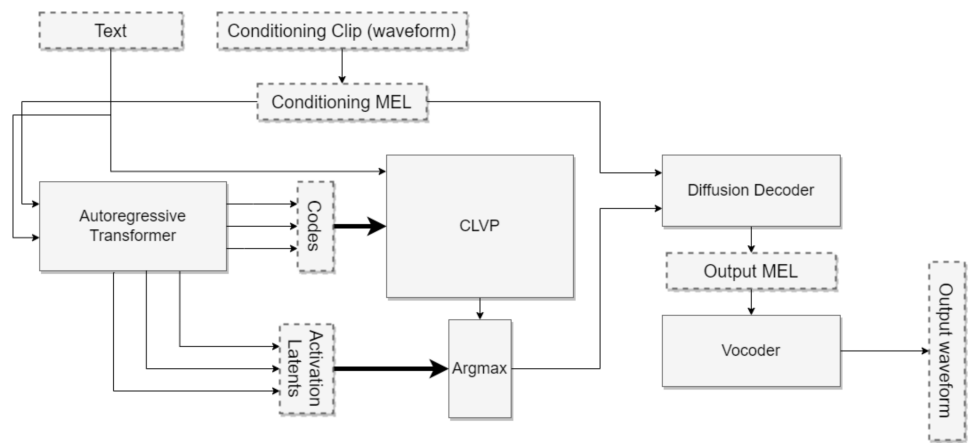

# Install modules

In [ ]:
!nvidia-smi

Fri Apr 12 08:33:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Clone repository and install all required modules

In [ ]:
!git clone https://github.com/neonbjb/tortoise-tts.git > /dev/null 2>&1
%cd tortoise-tts
!pip3 install -r requirements.txt > /dev/null 2>&1
!python3 setup.py install > /dev/null 2>&1

/content/tortoise-tts


#### Step 0: Download model weights and init all models

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

import gc
import IPython

from tortoise.api import TextToSpeech, fix_autoregressive_output
from tortoise.utils.audio import load_audio, load_voice, load_voices, denormalize_tacotron_mel
from tortoise.utils.diffusion import SpacedDiffusion, space_timesteps, get_named_beta_schedule
from contextlib import contextmanager

# Download TorToise models
tts = TextToSpeech(kv_cache=True)

# This allows to temporarily load a model to VRAM and offload the model to RAM after execution
@contextmanager
def temporary_cuda(model):
    # load model to VRAM (GPU)
    m = model.to("cuda")
    yield m
    # offload model again to RAM (CPU)
    m = model.cpu()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at jbetker/wav2vec2-large-robust-ft-libritts-voxpopuli were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jbetker/wav2vec2-large-robust-ft-libritts-voxpopuli and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.o

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

autoregressive.pth:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_decoder.pth:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

clvp2.pth:   0%|          | 0.00/976M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


vocoder.pth:   0%|          | 0.00/391M [00:00<?, ?B/s]

# Autoregressive Transformer

#### Step 1: Define text and voice for which speech is to be generated

In [ ]:
text = "we are exploring how the Tortoise model works under the hood"

# Pick one of the voices from the voices folder
voice = 'william'
# Load voice samples (wav files) as tensor
voice_samples, _ = load_voice(voice)

#### Step 2: Calculate latent vector characterising the voice in the given samples

In [ ]:
# get_conditioning_latents method:
# Input: list of audio samples (each as tensor) of a particular voice
# Processing of gpt_conditioning:
# 1. Clip audio sample to 6s (132300 using a 22.05KhZ sample rate) length by
# -  Either padding the sample with 0s
# -  or randomly shortening the sample
# 2. Convert 6s audio sample to mel spectrogram
# 3. Compute speaker embedding (expressive vectors that encode aspects of the
# -  provided clips like voice, intonation, and acoustic) using learned encoder
# 4. Calculate mean of all speaker embeddings to get final speaker embedding
# Processing of diffusion_conditioning:
# Similar approach to gpt_conditioning
# Output: gpt_conditioning, diffusion_conditioning
gpt_conditioning, diffusion_conditioning = tts.get_conditioning_latents(voice_samples)

## Autoregressive Model
##### Input: Text, Speaker Conditioning
##### Output: N x Mel token sequences

#### **Flow**

- Transform voice samples to speaker embedding
- Tokenize text and transform tokens to text embeddings
- Stack speaker embedding and text embeddings as input sequence
- Generation of MEL tokens based on input sequence

#### Step 3: Tokenize text and transform tokens to text embeddings

In [ ]:
# Mapping input text to tokens that efficiently represent the input text
text_tokens = torch.IntTensor(tts.tokenizer.encode(text)).unsqueeze(0)
# A beginning of sentence token (BOS) is prepended and an end of sentence
# token (EOS) is appended, indicating when the input text begins and ends.
text_inputs = torch.cat((torch.IntTensor([[tts.autoregressive.start_text_token]]),
                        text_tokens,
                        torch.IntTensor([[tts.autoregressive.stop_text_token]])),
                        dim=1).to(tts.device)

with temporary_cuda(tts.autoregressive) as autoregressive:
  # Element-wise add positional information to the embedded input text
  text_emb = autoregressive.text_embedding(text_inputs) + autoregressive.text_pos_embedding(text_inputs)

#### Step 4: Combine speaker conditioning and text embeddings as input

In [ ]:
# Add a dimensionality to match the shape of the text embedding
gpt_conditioning = gpt_conditioning.unsqueeze(1)
# Concatenate the speaker conditioning and text embeddings
input_embedding = torch.cat([gpt_conditioning, text_emb], dim=1)

#### Step 5: Create "fake inputs"


In [ ]:
# While our input_embedding consists of float values, the autoregressive
# model returns a sequence of discrete tokens (int or long type) and expects
# an input of discrete tokens. We therefore create a tensor of the same size
# as our input_embedding containing long values.
fake_inputs = torch.full((input_embedding.shape[0], input_embedding.shape[1] + 1), fill_value=1, dtype=torch.long, device=text_emb.device)
print(fake_inputs.shape)
# The start_mel_token is assigned to the last value of the input sequence to
# indicate to the LLM (GPT) that it should subsequently generate mel tokens.
fake_inputs[:, -1] = 8192 # 8192 = start_mel_token
# The trunc_index allows to separate the input sequence from the generated
# tokens later on
trunc_index = fake_inputs.shape[1]

torch.Size([1, 40])


#### Step 6: Generate Mel token sequences

In [ ]:
# restricts the Mel code sequence length
# each unit is 1/20 of a second -> 250*0.05 = 12.5 seconds
mel_seq_dim = 250

# number of Mel code sequences to be generated
num_return_sequences = 16

with torch.no_grad(), temporary_cuda(tts.autoregressive) as autoregressive:
  # generate mel code sequences given the input text and voice samples
  autoregressive.inference_model.store_mel_emb(input_embedding)
  # https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate
  gpt_output = autoregressive.inference_model.generate(fake_inputs, # input
                                        bos_token_id=tts.autoregressive.start_mel_token,
                                        pad_token_id=tts.autoregressive.stop_mel_token,
                                        eos_token_id=tts.autoregressive.stop_mel_token, # determines end of generation process
                                        max_new_tokens=mel_seq_dim, # maximum number of generated tokens (Mel codes)
                                        num_return_sequences=num_return_sequences,
                                        do_sample=True,
                                        top_p=.8,
                                        temperature=.8,
                                        repetition_penalty=2.0
                                        )
  generated_mel_codes = gpt_output[:, trunc_index:]
  # in case the GPT model generates sequences with less
  # than 250 Mel codes, the sequence will be padded
  padding_needed = mel_seq_dim - generated_mel_codes.shape[1]
  generated_mel_codes = F.pad(generated_mel_codes, (0, padding_needed), value=autoregressive.stop_mel_token)

# CLVP

## CLVP Model
##### Input: Text, N x Mel token sequences
##### Output: N x Score (float value)

#### Determine best MEL token sequence using CLVP model

The CLVP model (Contrastive Language-Voice Pretrained Transformer) outputs a score measuring the similarity/correlation between the input text and a generated MEL token sequence.

#### Step 7: Pick Top-K MEL token sequences using the CLVP Model (CLIP)

In [ ]:
# number of MEL token sequences (with highest CLVP score) to generate audio for
top_k = 4

with torch.no_grad(), temporary_cuda(tts.clvp) as clvp:
  for i in range(generated_mel_codes.shape[0]):
    # the fix_autoregressive_output function performs some padding to fix a
    # mismatch issue between what the diffusion model was trained on and what
    # the autoregressive code generator creates (which has no padding or end).
    generated_mel_codes[i] = fix_autoregressive_output(generated_mel_codes[i], tts.autoregressive.stop_mel_token)
  text_input = text_tokens.repeat(generated_mel_codes.shape[0], 1).to(tts.device)
  # calculate the CLVP scores for all MEL code sequences
  clvp_scores = clvp(text_input, generated_mel_codes, return_loss=False)
  # continue only with the top_k best ranked MEL code sequences
  topk_mel_codes_indices = torch.topk(clvp_scores, k=top_k).indices
  generated_mel_codes = generated_mel_codes[topk_mel_codes_indices]

## Autoregressive Model
##### Input: Text, N x Mel token sequences
##### Output: N x Latent representations inside AR model

#### Step 8: Obtaining GPT latents for generated MEL code sequences as input for the diffusion model

In [ ]:
with torch.no_grad(), temporary_cuda(tts.autoregressive) as autoregressive:
    # repeat speech_conditioning k-times to match shape of generated_mel_codes
    speech_conditioning = gpt_conditioning.squeeze().repeat(top_k, 1).to("cuda")
    # repeat text_tokens k-times to match shape of generated_mel_codes
    text_inputs = text_tokens.repeat(top_k, 1).to("cuda")
    # number of input text tokens as scalar (can be ignored
    # as the this argument is internally not used)
    text_lengths = torch.tensor([text_tokens.shape[-1]], device="cuda")
    # wav_lengths -> length of the output audio (number of mel codes * Mel compression rate)
    # Mel spectogram compresses audio 256 times. Mel codes compress Mel spectogram 4 times.
    # Mel compression rate = 256*4 = 1024
    wav_lengths = torch.tensor([generated_mel_codes.shape[-1]*tts.autoregressive.mel_length_compression], device="cuda")

    # obtain the latent representations of each mel token inside the
    # autoregressive model
    gpt_latents = autoregressive(speech_conditioning,
                                 text_inputs,
                                 text_lengths,
                                 generated_mel_codes,
                                 wav_lengths,
                                 return_latent=True,
                                 clip_inputs=False)

#### Step 9: Pre-process intermediate latents for better speech synthesis results

In [ ]:
preprocessed_gpt_latents = []
for i in range(generated_mel_codes.shape[0]):
    mel_codes = generated_mel_codes[i].unsqueeze(0).cpu()
    # Find the first occurrence of the "calm" token and trim the codes to that.
    calm_token = 83
    # This code works because all EOS and padding tokens were replaced by the
    # calm_token when the fix_autoregressive_output method was called earlier.
    calm_tokens = 0
    for j in range(mel_codes.shape[-1]):
        if mel_codes[0, j] == calm_token:
            calm_tokens += 1
        else:
            calm_tokens = 0
        if calm_tokens > 8:  # 8 calm tokens give the diffusion model some "breathing room" to terminate speech.
            preprocessed_gpt_latents.append(gpt_latents[i, :j].cpu())
            break

# Diffusion Decoder

## Diffusion Model
##### Input: Latent representation, Speaker Conditioning
##### Output: Mel spectrogram

#### Step 10: Initializing the Diffusion Sampler

In [ ]:
# OpenAI Paper (Prafulla Dhariwal, Alex Nichol) - Diffusion Models Beat GANs on Image Synthesis.
# https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/respace.py
trained_diffusion_steps = 4000
desired_diffusion_steps = 250
sampler = SpacedDiffusion(use_timesteps=space_timesteps(trained_diffusion_steps, [desired_diffusion_steps]),
                          model_mean_type='epsilon', # the model predicts added noise epsilon
                          model_var_type='learned_range', # determines how the model outputs the variance
                          loss_type='mse', # loss used, not relevant for inference
                          betas=get_named_beta_schedule('linear', trained_diffusion_steps), # determines the amount of noise added or subtracted at each step, not relevant for inference though
                          # Conditioning-free diffusion performs two forward passes for
                          # each diffusion step: one with the outputs of the autoregressive model and one with no conditioning priors. The output
                          # of the two is blended according to the cond_free_k value below. Conditioning-free diffusion dramatically improves realism.
                          conditioning_free=True,
                          # As cond_free_k increases, the output becomes dominated by the conditioning-free signal.
                          # Formula is: output=cond_present_output*(cond_free_k+1)-cond_absenct_output*cond_free_k
                          conditioning_free_k=2
                          )

#### Step 11: Iteratively denoise noisy input image to Mel spectrogram

In [ ]:
%%time
with (
    temporary_cuda(tts.diffusion) as diffusion_model,
    torch.no_grad()
     ):
    generated_mel_spectograms = []
    for gpt_latents in preprocessed_gpt_latents:
        gpt_latents = gpt_latents.unsqueeze(0).to(tts.device)
        # 4x because the Mel codes compress a Mel spectrogram by factor 4
        # 24000 // 22050 allows consideration of 24kHz sampling rate expected by the vocoder
        output_seq_len = gpt_latents.shape[1] * 4 * 24000 // 22050
        # 100 = mel-filter channels (or banks) expected by the vocoder
        output_shape = (gpt_latents.shape[0], 100, output_seq_len)
        # preparing the conditioning
        precomputed_embeddings = diffusion_model.timestep_independent(gpt_latents, diffusion_conditioning, output_seq_len, False)
        # define noisy image which will be iteratively denoised
        img = torch.randn(output_shape, device=gpt_latents.device)
        for i in reversed(range(desired_diffusion_steps)):
            # current time step as scalar (or list of scalars)
            t = torch.tensor([i] * output_shape[0], device=tts.device)
            # denoise img at time step t using the precomputed conditioning
            # and the spaced diffusion sampler
            out = sampler.p_sample(
                diffusion_model,
                img,
                t,
                model_kwargs={'precomputed_aligned_embeddings': precomputed_embeddings},
            )
            # assign img with prediction from the diffusion model for
            # img at time step t-1
            img = out["sample"]
        generated_mel_spectograms.append(img.cpu())

CPU times: user 1min 26s, sys: 409 ms, total: 1min 26s
Wall time: 1min 29s


# Vocoder

#### Step 12: Transform Mel spectrogram to waveform audio

In [ ]:
with temporary_cuda(tts.vocoder) as vocoder:
    generated_speech = []
    for mel_spectogram in generated_mel_spectograms:
        # the generated normalized Mel spectrogram must be
        # "denormalized" before applying to the vocoder
        mel_spectogram = denormalize_tacotron_mel(mel_spectogram.to(tts.device))[:,:,:output_seq_len]
        # transform generated Mel spectrogram to waveform audio
        wav = vocoder.inference(mel_spectogram)
        generated_speech.append(wav.cpu())

#### Step 13: Play generated speech

In [ ]:
for index, speech in enumerate(generated_speech):
    torchaudio.save(f'generated_{index}.wav', speech.squeeze(0), 24000)
    IPython.display.display(IPython.display.Audio(f'generated_{index}.wav'))